# Examples of time series

# Setup

In [1]:
!pip install -U tf-nightly-2.0-preview

    100% |████████████████████████████████| 95.2MB 536kB/s eta 0:00:01    50% |████████████████                | 47.9MB 10.8MB/s eta 0:00:05
    100% |████████████████████████████████| 51kB 15.1MB/s ta 0:00:01
    100% |████████████████████████████████| 450kB 10.7MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 14.8MB/s ta 0:00:01
    100% |████████████████████████████████| 3.8MB 4.5MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 13.7MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 14.4MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 10.8MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 14.6MB/s ta 0:00:01


  Stored in directory: /home/dmytro/.cache/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Stored in directory: /home/dmytro/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
Successfully built wrapt opt-einsum
tb-nightly 2.1.0a20191026 has requirement grpcio>=1.24.3, but you'll have grpcio 1.17.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
Cannot uninstall 'wrapt'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Trend and Seasonality

In [4]:
def trend(time, slope=0):
    return slope * time

Time series that just trends upward:

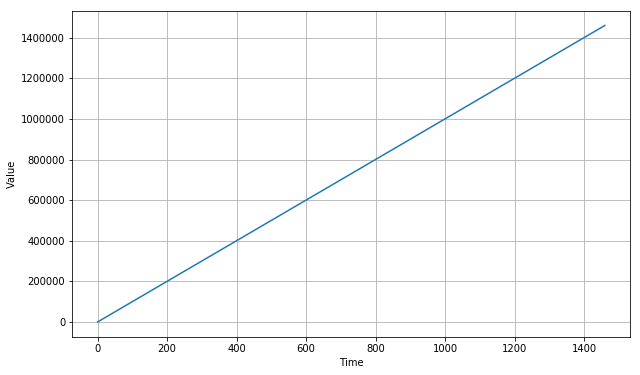

In [9]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Generate a time series with a seasonal pattern:

In [11]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

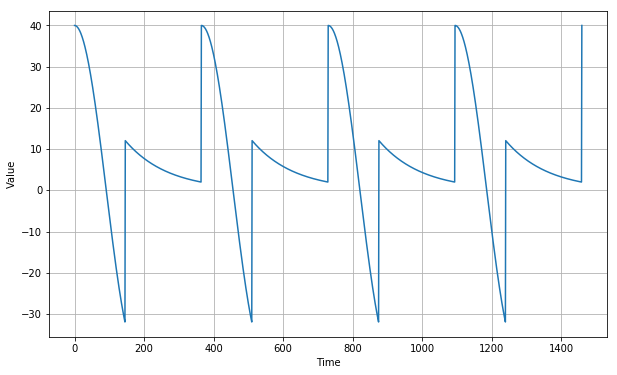

In [12]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Time series with both trend and seasonality:

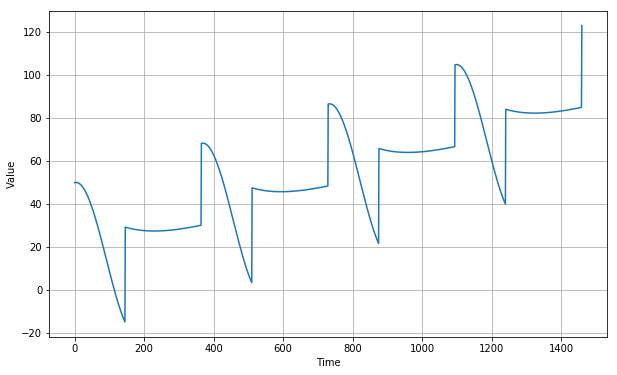

In [13]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Noise

In [14]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

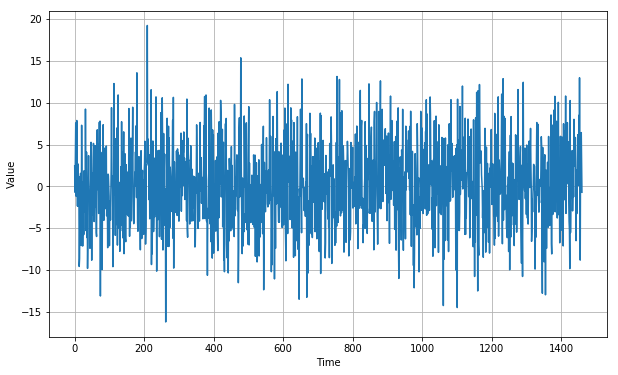

In [15]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

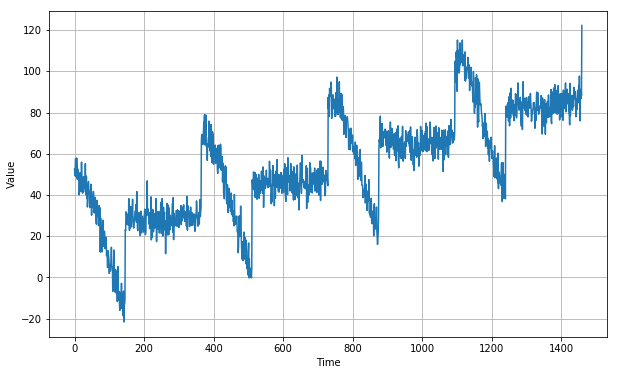

In [16]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [17]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [18]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [21]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

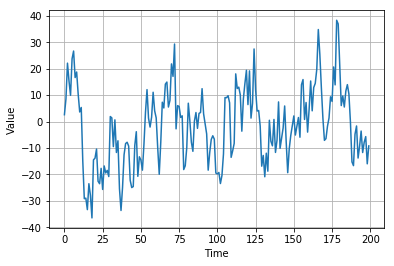

In [23]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

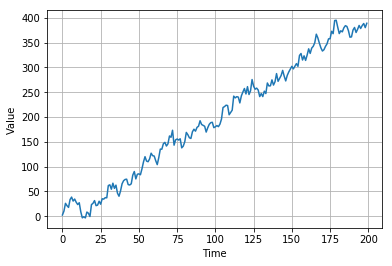

In [25]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

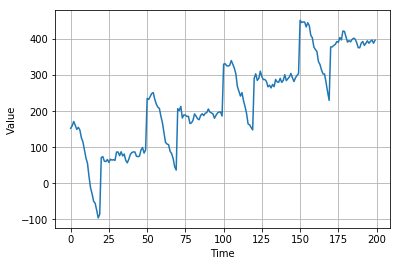

In [26]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

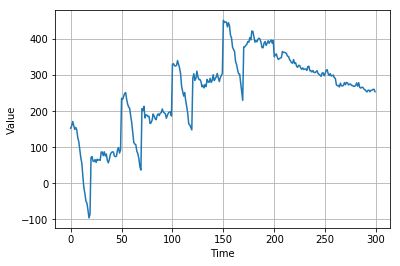

In [27]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [28]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

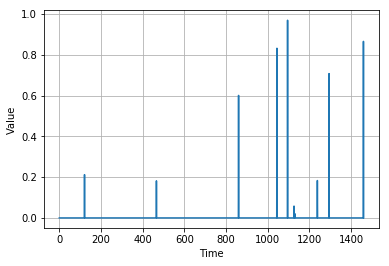

In [29]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [30]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

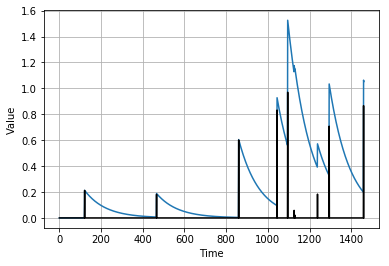

In [31]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

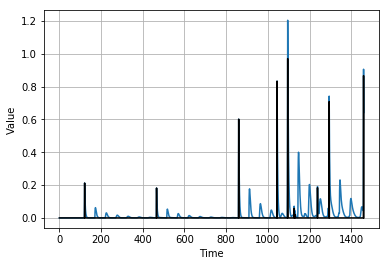

In [32]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

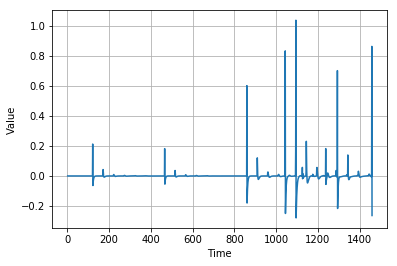

In [33]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

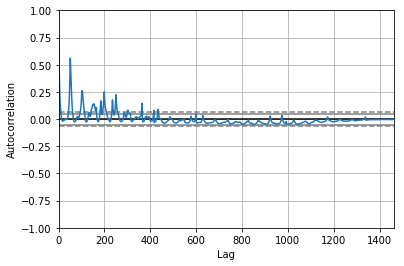

In [34]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [0]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Tue, 30 Jul 2019   AIC                          -4432.855
Time:                        17:40:55   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

In [0]:
df = pd.read_csv("sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

In [0]:
series.plot(figsize=(12, 5))

In [0]:
series["1995-01-01":].plot()

In [0]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

In [0]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [0]:
autocorrelation_plot(series.diff(1)[1:])

In [0]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

In [0]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [0]:
116.7 - 104.3

In [0]:
[series.autocorr(lag) for lag in range(1, 50)]

In [0]:
pd.read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
Read a comma-separated values (csv) file into DataFrame.


In [0]:
from pandas.plotting import autocorrelation_plot

series_diff = series
for lag in range(50):
  series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

In [0]:
import pandas as pd

series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()